# Import Dependencies and Define Functions

In [121]:
%matplotlib notebook

#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import os
from tkinter import Tk
from tkinter.filedialog import askdirectory
from iapws import IAPWS97 as steam_prop
import matplotlib.animation as animation
from matplotlib.widgets import Slider

In [2]:
#Define a function that calculates the density for a given pressure and temperature
def calc_rho(p, t):
    
    #convert psia to MPA
    pressure = p*0.00689476
    
    #convert farenheit to Kelvin
    temp = (t - 32)*5/9 + 273.15
    
    #get the density 
    r = steam_prop(P=pressure, T=temp).v
    rho = steam_prop(P=pressure, T=temp).rho
    
    #convert density from kg/M^3 to lb/ft^3
    rho = rho*0.062428
    
    return rho

# Open a Project

In [3]:
#Ask if user would like to open a project
open_flag = input("Would you like to return to an existing project?(y/n)")

#If user requests to open project, request project name
if open_flag == "y":
    try:
        path = askdirectory(title="Select Project Folder")
    except:
        print("File open failed.")

Would you like to return to an existing project?(y/n)y


In [4]:
#get project name
list_path = path.split(sep="/")
open_project = list_path[-1]
project = open_project

#Load available dataframes
try:
    single_dmd_df = pd.read_csv(f"projects/{open_project}/single_dmd_curve.csv")
except:
    print("Couldn't load 'single_dmd_curve.csv' from project")
    
try:
    gv_demand_df = pd.read_csv(f"projects/{open_project}/sequential_dmd_curve.csv")
    #Use integer division to get number of governor valves
    gov_no = len(gv_demand_df.columns)//2
except:
    print("Couldn't load 'sequential_dmd_curve.csv' from project")
    
try:
    design_df = pd.read_csv(f"projects/{open_project}/design_data.csv")
except:
    print("Couldn't load 'design_data.csv' from project")
    

# Define a New Project

In [80]:
#Get a project name from the user
project = input("What would you like to call this project?")

What would you like to call this project?Bowen1


In [ ]:
#Create a Directory for the project
try:
    os.mkdir("projects")
except:
    print("Couldn't make new 'projects' directory")
try:
    os.mkdir(f"projects/{project}")
except:
    print(f"Couldn't make new '{project}' directory")

# Define Single Mode Governor Demand to Valve Position Curve

In [ ]:
#Import Governor Demand to Single Valve Demand curve
user_x = input("Enter the x values for Single Valve Mode")
user_y = input("Enter the y values for Single Valve Mode")
list_x = user_x.split()
list_y = user_y.split()

    
#convert list of strings to list of floats
x_axis = [float(i) for i in list_x]
y_axis = [float(i) for i in list_y]
    
#Tell user what was entered
print(f"You entered {len(x_axis)} x values and {len(y_axis)} y values")
data = {"Governor Demand" : x_axis, "Valve Position Demand" : y_axis}
single_dmd_df = pd.DataFrame(data)

#Save Dataframe to csv
single_dmd_df.to_csv(f"projects/{project}/single_dmd_curve.csv")

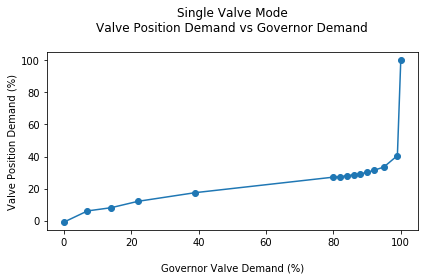

In [37]:
#plot the governor demand single valve curve
plt.plot(single_dmd_df["Governor Demand"], single_dmd_df["Valve Position Demand"], "o-")
plt.title("Single Valve Mode\nValve Position Demand vs Governor Demand\n")
plt.ylabel("Valve Position Demand (%)")
plt.xlabel("\nGovernor Valve Demand (%)")
plt.tight_layout()

#save the figure to the project directory
plt.savefig(f"projects/{project}/single_dmd_curve.png")

# Define Sequential Mode Governor Demand to Valve Positions Curves

In [11]:
#Get number of governor valves from the user
gov_no = int(input("How many governor valves are there?"))

#Create a list of column titles for Pandas dataframe
titles = []
for i in range(gov_no):
    titles.append("GV"+str(i+1)+" x")
    titles.append("GV"+str(i+1)+" y")
print(titles)

How many governor valves are there?8
['GV1 x', 'GV1 y', 'GV2 x', 'GV2 y', 'GV3 x', 'GV3 y', 'GV4 x', 'GV4 y', 'GV5 x', 'GV5 y', 'GV6 x', 'GV6 y', 'GV7 x', 'GV7 y', 'GV8 x', 'GV8 y']


In [12]:
#For each governor valve enter the
gv_demand_curves = []
for i in range(gov_no):
    user_x = input(f"Copy the x values for GV #{i+1} ")
    user_y = input(f"Copy the y values for GV #{i+1} ")
    list_x = user_x.split()
    list_y = user_y.split()
    
    #convert list of strings to list of floats
    list_x = [float(i) for i in list_x]
    list_y = [float(i) for i in list_y]
    
    #Append lists to the master list
    gv_demand_curves.append(list_x)
    gv_demand_curves.append(list_y)

Copy the x values for GV #1 0 84 85 90 92 95 96 99.2 99.5 100 100.1 100.2 100.3 101
Copy the y values for GV #1 -0.5 0 2 14.6 22 100 101 101 101 101 101 101 101 101
Copy the x values for GV #2 0 0.5 44 51.6 56 65 75 80 84 85 86 88 90 100
Copy the y values for GV #2 -1 -0.5 0.5 5.2 12 17 23.5 29 33 36.8 41 50 100 101
Copy the x values for GV #3 0 5 19.97 29 34 38.5 42 46 54.4 75 85 90 95 100
Copy the y values for GV #3 0 6 20 28 29.8 31.15 35.6 37.5 40.5 52 100 101 101 101
Copy the x values for GV #4 0 5 19.97 29 34 38.5 42 46 54.4 75 85 90 95 100
Copy the y values for GV #4 0 6 20 28 29.8 31.15 35.6 37.5 40.5 52 100 101 101 101
Copy the x values for GV #5 0 5 19.97 29 34 38.5 42 46 54.4 75 85 90 95 100
Copy the y values for GV #5 0 6 20 28 29.8 31.15 35.6 37.5 40.5 52 100 101 101 101
Copy the x values for GV #6 0 5 19.97 29 34 38.5 42 46 54.4 75 85 90 95 100
Copy the y values for GV #6 0 6 20 28 29.8 31.15 35.6 37.5 40.5 52 100 101 101 101
Copy the x values for GV #7 0 0.5 44 51.6 56 6

In [17]:
#Define a dictionary of the governor valve demand curves
dictionary = {}
for i in range(2*gov_no):
    dictionary.update({titles[i] : gv_demand_curves[i]})

#Use dictionary to create a pandas dataframe
gv_demand_df = pd.DataFrame(dictionary)
gv_demand_df

#Save Dataframe to csv
gv_demand_df.to_csv(f"projects/{project}/sequential_dmd_curve.csv")


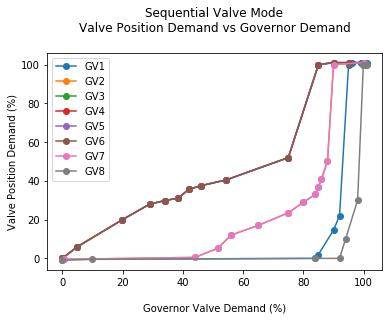

In [40]:
#Create a plot of all the governor demand curves
for i in range(gov_no):
    plt.plot(gv_demand_df.iloc[:,i*2], gv_demand_df.iloc[:,i*2+1], 'o-')

#Create Labels
legend_list = [f"GV{i+1}" for i in range(gov_no)]
plt.legend(legend_list)

#Add labels
plt.title("Sequential Valve Mode\nValve Position Demand vs Governor Demand\n")
plt.ylabel("Valve Position Demand (%)")
plt.xlabel("\nGovernor Valve Demand (%)")

#save figure
plt.savefig(f"projects/{project}/sequential_dmd_curve.png")

# Define the Design Performance

In [19]:
#Define the desired performance

#get a list from the user comparing governor demand and measured steam flow
input_dmd = input("input governor demand historical data")
input_steam_flow = input("input steam flow historical data")
input_throttle_p = input("input throttle pressure historical data")
input_steam_temp = input("input main steam temperature historical data")
input_1st_p = input("input first stage pressure historical data")
input_mwg = input("input Generator MW historical data")

#split input by spaces
list_dmd = input_dmd.split()
list_steam_flow = input_steam_flow.split()
list_throttle_p = input_throttle_p.split()
list_steam_temp = input_steam_temp.split()
list_1st_p = input_1st_p.split()
list_mwg = input_mwg.split()
    
#convert list of strings to list of floats
list_dmd = [float(i) for i in list_dmd]
list_steam_flow = [float(i) for i in list_steam_flow]
list_throttle_p = [float(i) for i in list_throttle_p]
list_steam_temp = [float(i) for i in list_steam_temp]
list_1st_p = [float(i) for i in list_1st_p]
list_mwg = [float(i) for i in list_mwg]

input governor demand historical data0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 19.95898438 20.59375 20.59375 21.09765625 25.27148438 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 25.79101563 26.29296875 26.80664063 26.80664063 27.32421875 27.828125 27.828125 27.828125 28.33203125 28.33203125 28.83203125 29.83398438 30.8359375 31.84570313 34.3828125 35.38476563 36.38476563 36.38476563 36.38476563 36.38476563 37.39257813 38.90039063 41.41210938 42.91992188 44.93945313 47.45507813 48.45898438 47.45117188 46.95117188 46.95117188 48.984375 49.98828125 51.4921875 51.99414063 51.99414063 51.9

input first stage pressure historical data0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7.634063721 3.837641001 43.65960693 36.15786743 35.89134979 36.14497757 42.91465759 123.2182922 139.554184 141.2626038 142.3866882 144.1427612 148.0781708 149.4593201 149.7753448 150.3224792 151.3129272 152.2172852 152.18396 152.1380005 152.5114594 151.710083 151.7161102 151.8053131 151.8507538 151.7209167 152.2037811 152.4288483 241.0627594 281.822113 410.6161499 505.1190491 589.7111816 589.984436 637.4505005 666.18396 696.1891479 738.9607544 792.5067139 811.4208374 861.4943237 918.1005249 944.7514648 984.3876953 1045.14917 1076.528198 1100.933716 1107.697021 1114.374878 1112.366333 1129.433838 1184.761841 1260.421753 1314.001587 1376.696533 1421.546753 1487.30603 1477.256348 1460.503906 1444.635742 1536.522705 1532.39856

In [21]:
#Define a dictionary of the governor valve demand curves
dictionary = {
    "Governor Demand (Design)" : list_dmd,
    "Steam Flow (Design)" : list_steam_flow,
    "Throttle Pressure" : list_throttle_p,
    "Main Steam Temperature" : list_steam_temp,
    "First Stage Pressure (Design)" : list_1st_p,
    "Generator MWG" : list_mwg
}

#Use dictionary to create a pandas dataframe
design_df = pd.DataFrame(dictionary)

#Save dataframe to csv
design_df.to_csv(f"projects/{project}/design_data.csv")

# Create a model that predicts the Flow for a given Governor Demand

## Define Trim Curves

In [15]:
#Start with linear trim curves
trim_list = []

#Define the resolution
res = 200
top = 100 + 100/res
step = 100/res

for x in range(gov_no):
    trim_list.append(numpy.arange(0,top,step))
    trim_list.append(numpy.arange(0,top,step))

#Create a list of column titles for Pandas dataframe
titles = []
for i in range(gov_no):
    titles.append("GV"+str(i+1)+" lift")
    titles.append("GV"+str(i+1)+" area")
    
#Define a dictionary of the governor trim curves
dictionary = {}
for i in range(2*gov_no):
    dictionary.update({titles[i] : trim_list[i]})

#Use dictionary to create a pandas dataframe
gv_trim_df = pd.DataFrame(dictionary)

#Save Dataframe to csv
gv_trim_df.to_csv(f"projects/{project}/gov_trim_curve.csv")
print(gv_trim_df)

     GV1 lift  GV1 area  GV2 lift  GV2 area  GV3 lift  GV3 area  GV4 lift  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.5       0.5       0.5       0.5       0.5       0.5       0.5   
2         1.0       1.0       1.0       1.0       1.0       1.0       1.0   
3         1.5       1.5       1.5       1.5       1.5       1.5       1.5   
4         2.0       2.0       2.0       2.0       2.0       2.0       2.0   
5         2.5       2.5       2.5       2.5       2.5       2.5       2.5   
6         3.0       3.0       3.0       3.0       3.0       3.0       3.0   
7         3.5       3.5       3.5       3.5       3.5       3.5       3.5   
8         4.0       4.0       4.0       4.0       4.0       4.0       4.0   
9         4.5       4.5       4.5       4.5       4.5       4.5       4.5   
10        5.0       5.0       5.0       5.0       5.0       5.0       5.0   
11        5.5       5.5       5.5       5.5       5.5       5.5       5.5   

### Prompt User to Adjust Piecewise fit for Steam Flow vs. Governor Demand

<IPython.core.display.Javascript object>


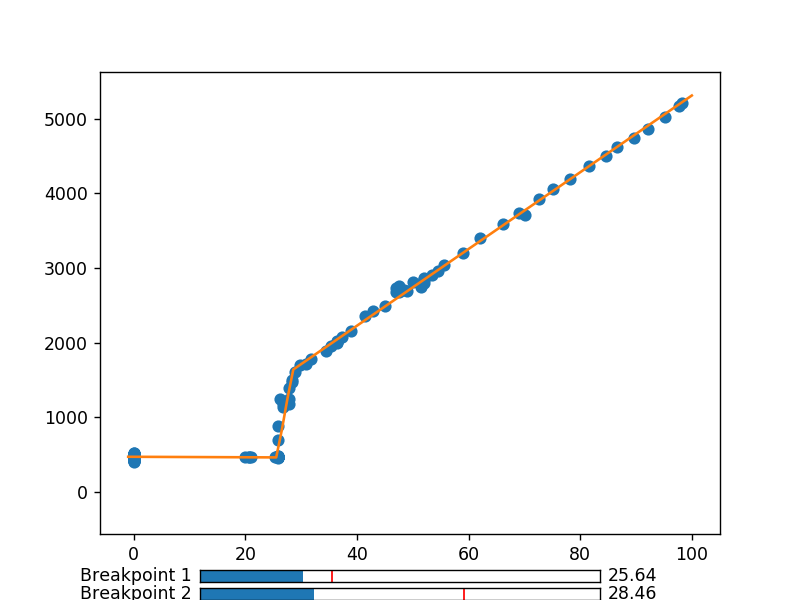

In [209]:
x = design_df["Governor Demand (Design)"].tolist()
y = design_df["Steam Flow (Design)"].tolist()

#global x0
#global y0
x0 = 20
x1 = 31

def piecewise_linear(x, y0, y1, b0, b1, b2):
    global x0
    global x1

    return np.piecewise(x, 
                        [x < x0, 
                         (x >= x0) & (x < x1), 
                         x >= x1], 
                        [lambda x: b0*x + y0, 
                         lambda x: b1*x + y1-b1*x1,
                         lambda x: b2*x + y1-b2*x1])
  
p, e = optimize.curve_fit(piecewise_linear, x, y)

new_x = np.linspace(-1, 100, 100)

# Create figure and axis objects
fig, ax = plt.subplots()

data, = plt.plot(x, y, 'o')
fit, = plt.plot(new_x, piecewise_linear(new_x, *p))

#left, bottom, width, height
ax_break1 = plt.axes([0.25, .03, 0.50, 0.02])
ax_break2 = plt.axes([0.25, .00, 0.50, 0.02])

slider1 = Slider(ax_break1, 'Breakpoint 1', 0, 100, valinit=33)
slider2 = Slider(ax_break2, 'Breakpoint 2', 0, 100, valinit=66)

def update(val):
    global x0
    global x1
    x0 = slider1.val
    x1 = slider2.val
    # update curve
    p, e = optimize.curve_fit(piecewise_linear, x, y)
    fit.set_ydata(piecewise_linear(new_x, *p))
    # redraw canvas while idle
    fig.canvas.draw_idle()

# call update function on slider value change
slider1.on_changed(update)
slider2.on_changed(update)


plt.show()

In [210]:
dictionary = {
    "Governor Demand" : ax.get_children()[1]._x,
    "Steam Flow" : ax.get_children()[1]._y
}
steam_flow_model_df = pd.DataFrame(dictionary)
steam_flow_model_df.to_csv(f"projects/{project}/steam_flow_model.csv")


#fig, ax = plt.subplots()
#plt.plot(steam_flow_model[0], steam_flow_model[1])
#plt.show()

### Prompt User to Adjust Piecewise fit for Throttle Pressure vs. Governor Demand

<IPython.core.display.Javascript object>


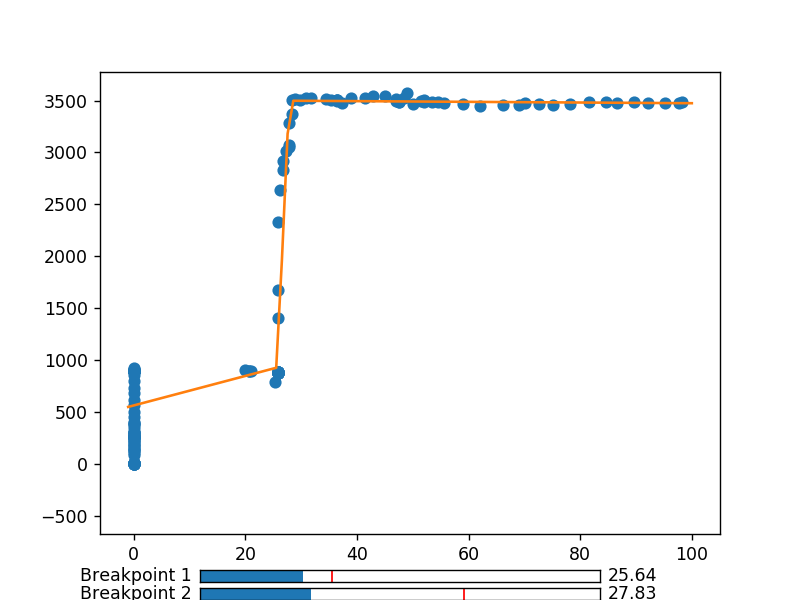

In [211]:
x = design_df["Governor Demand (Design)"].tolist()
y = design_df["Throttle Pressure"].tolist()

#global x0
#global y0
x0 = 20
x1 = 31

def piecewise_linear(x, y0, y1, b0, b1, b2):
    global x0
    global x1

    return np.piecewise(x, 
                        [x < x0, 
                         (x >= x0) & (x < x1), 
                         x >= x1], 
                        [lambda x: b0*x + y0, 
                         lambda x: b1*x + y1-b1*x1,
                         lambda x: b2*x + y1-b2*x1])
  
p, e = optimize.curve_fit(piecewise_linear, x, y)

new_x = np.linspace(-1, 100, 100)

# Create figure and axis objects
fig, ax = plt.subplots()

data, = plt.plot(x, y, 'o')
fit, = plt.plot(new_x, piecewise_linear(new_x, *p))

#left, bottom, width, height
ax_break1 = plt.axes([0.25, .03, 0.50, 0.02])
ax_break2 = plt.axes([0.25, .00, 0.50, 0.02])

slider1 = Slider(ax_break1, 'Breakpoint 1', 0, 100, valinit=33)
slider2 = Slider(ax_break2, 'Breakpoint 2', 0, 100, valinit=66)

def update(val):
    global x0
    global x1
    x0 = slider1.val
    x1 = slider2.val
    # update curve
    p, e = optimize.curve_fit(piecewise_linear, x, y)
    fit.set_ydata(piecewise_linear(new_x, *p))
    # redraw canvas while idle
    fig.canvas.draw_idle()

# call update function on slider value change
slider1.on_changed(update)
slider2.on_changed(update)


plt.show()

In [212]:
dictionary = {
    "Governor Demand" : ax.get_children()[1]._x,
    "Throttle Pressure" : ax.get_children()[1]._y
}
tp_model_df = pd.DataFrame(dictionary)
tp_model_df.to_csv(f"projects/{project}/tp_model.csv")


#fig, ax = plt.subplots()
#plt.plot(steam_flow_model[0], steam_flow_model[1])
#plt.show()

### Prompt User to Adjust Piecewise fit for Main Steam Temp vs. Governor Demand

<IPython.core.display.Javascript object>


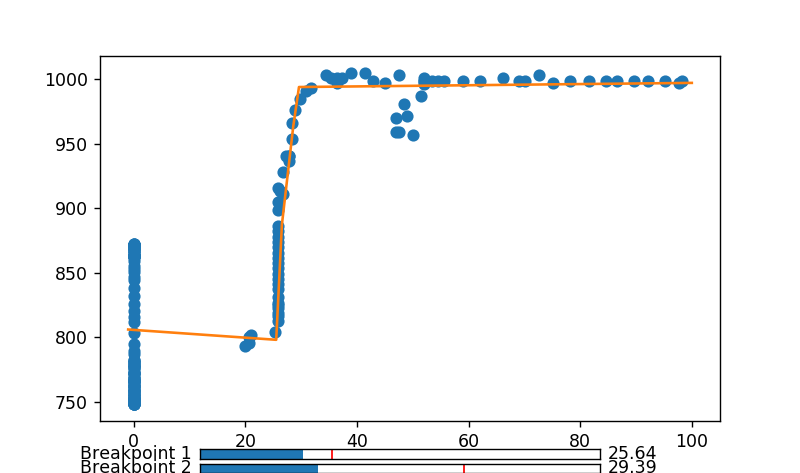

In [213]:
x = design_df["Governor Demand (Design)"].tolist()
y = design_df["Main Steam Temperature"].tolist()

#global x0
#global y0
x0 = 20
x1 = 31

def piecewise_linear(x, y0, y1, b0, b1, b2):
    global x0
    global x1

    return np.piecewise(x, 
                        [x < x0, 
                         (x >= x0) & (x < x1), 
                         x >= x1], 
                        [lambda x: b0*x + y0, 
                         lambda x: b1*x + y1-b1*x1,
                         lambda x: b2*x + y1-b2*x1])
  
p, e = optimize.curve_fit(piecewise_linear, x, y)

new_x = np.linspace(-1, 100, 100)

# Create figure and axis objects
fig, ax = plt.subplots()

data, = plt.plot(x, y, 'o')
fit, = plt.plot(new_x, piecewise_linear(new_x, *p))

#left, bottom, width, height
ax_break1 = plt.axes([0.25, .03, 0.50, 0.02])
ax_break2 = plt.axes([0.25, .00, 0.50, 0.02])

slider1 = Slider(ax_break1, 'Breakpoint 1', 0, 100, valinit=33)
slider2 = Slider(ax_break2, 'Breakpoint 2', 0, 100, valinit=66)

def update(val):
    global x0
    global x1
    x0 = slider1.val
    x1 = slider2.val
    # update curve
    p, e = optimize.curve_fit(piecewise_linear, x, y)
    fit.set_ydata(piecewise_linear(new_x, *p))
    # redraw canvas while idle
    fig.canvas.draw_idle()

# call update function on slider value change
slider1.on_changed(update)
slider2.on_changed(update)


plt.show()

In [215]:
dictionary = {
    "Governor Demand" : ax.get_children()[1]._x,
    "Main Steam Temperature" : ax.get_children()[1]._y
}
steam_temp_model_df = pd.DataFrame(dictionary)
steam_temp_model_df.to_csv(f"projects/{project}/steam_temp_model.csv")


#fig, ax = plt.subplots()
#plt.plot(steam_flow_model[0], steam_flow_model[1])
#plt.show()

### Prompt User to Adjust Piecewise fit for First Stage Pressure vs. Governor Demand

<IPython.core.display.Javascript object>


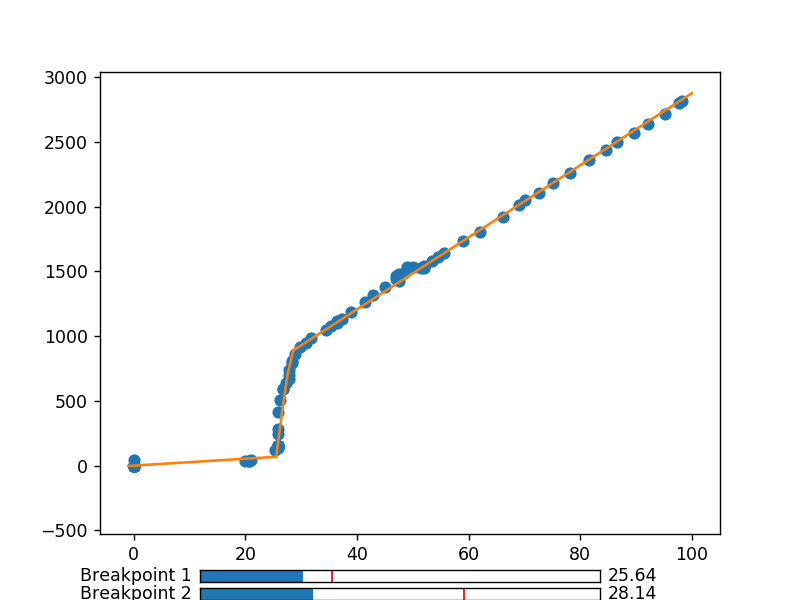

In [217]:
x = design_df["Governor Demand (Design)"].tolist()
y = design_df["First Stage Pressure (Design)"].tolist()

#global x0
#global y0
x0 = 20
x1 = 31

def piecewise_linear(x, y0, y1, b0, b1, b2):
    global x0
    global x1

    return np.piecewise(x, 
                        [x < x0, 
                         (x >= x0) & (x < x1), 
                         x >= x1], 
                        [lambda x: b0*x + y0, 
                         lambda x: b1*x + y1-b1*x1,
                         lambda x: b2*x + y1-b2*x1])
  
p, e = optimize.curve_fit(piecewise_linear, x, y)

new_x = np.linspace(-1, 100, 100)

# Create figure and axis objects
fig, ax = plt.subplots()

data, = plt.plot(x, y, 'o')
fit, = plt.plot(new_x, piecewise_linear(new_x, *p))

#left, bottom, width, height
ax_break1 = plt.axes([0.25, .03, 0.50, 0.02])
ax_break2 = plt.axes([0.25, .00, 0.50, 0.02])

slider1 = Slider(ax_break1, 'Breakpoint 1', 0, 100, valinit=33)
slider2 = Slider(ax_break2, 'Breakpoint 2', 0, 100, valinit=66)

def update(val):
    global x0
    global x1
    x0 = slider1.val
    x1 = slider2.val
    # update curve
    p, e = optimize.curve_fit(piecewise_linear, x, y)
    fit.set_ydata(piecewise_linear(new_x, *p))
    # redraw canvas while idle
    fig.canvas.draw_idle()

# call update function on slider value change
slider1.on_changed(update)
slider2.on_changed(update)


plt.show()

In [218]:
dictionary = {
    "Governor Demand" : ax.get_children()[1]._x,
    "First Stage Pressure" : ax.get_children()[1]._y
}
first_stage_model_df = pd.DataFrame(dictionary)
first_stage_model_df.to_csv(f"projects/{project}/first_stage_model.csv")


#fig, ax = plt.subplots()
#plt.plot(steam_flow_model[0], steam_flow_model[1])
#plt.show()

## Define the tables translating Governor Demand to Flow Coefficient 

In [ ]:
#define a function that gets the flow regime for a given jratio nd pratio
def get_regime(jratio, pratio):
    # return 1 if "Neither Choked"
    # return 2 if "Governor Choked"
    # return 3 if "Nozzle Choked"
    # return 4 if "Both Choked"
    
    alpha = 0.55
    
    #Define the intersection of the curves
    triple_point = alpha + (alpha - 1) *0.55**2/alpha
    
    #if jratio is to the right of the triple point, test for neither choked or nozzle choked
    if jratio > 0.55:
        
        #define the limit below which the nozzle is choked
        limit = alpha*jratio*(jratio-(-4*alpha+jratio**2+4)**0.5)/(2*(alpha-1))
        
        #test if the pratio is in "neither choked" or "nozzle choked" regime
        if pratio > limit:
            return 1
        else:
            return 3
    
    #if jratio is to the left of the triple point, test for neither choked, governor choked, or both choked
    else:
        
        #define the limit below which both are choked
        limit = triple_point/alpha*jratio
        
        #if the pratio is below the limit, the flow is "both choked"
        if pratio < limit:
            return 4
        
        #if not, define the limit below which the governover is choked
        else:
            limit = alpha + (alpha-1)*jratio**2/alpha
            
            #if the pratio is below the limit, the flow is "governor choked"
            if pratio < limit:
                return 2
            else:
                return 1

#print(get_regime(1,1))
#print(get_regime(0.2,0.01))
#print(get_regime(0.2,0.2))
#print(get_regime(1.5,0.2))


# Compare Actual to Desired Performance

For Governor Demands 0 to 100 in Single Valve Mode and Sequential Mode calculate:

1) The pressure ratio for each governor valve

2) The j for each governor valve

3) the jratio for each governor valve

4) the flow regime for each governor valve

5) the bowl pressure for each governor valve

6) the flow for each governor valve

7) the difference from the desired performance

In [251]:
# Define the governor demands to test against
top = 101
step = 1
gov_dmd = numpy.arange(0,top, step)

#Define the throttle pressure
tp = np.interp(gov_dmd, tp_model_df["Governor Demand"], tp_model_df["Throttle Pressure"])

#Define the steam temperatures
temperature = np.interp(gov_dmd, steam_temp_model_df["Governor Demand"], steam_temp_model_df["Main Steam Temperature"])

#Define the inlet densities
rho = []
for x in range(len(gov_dmd)):
    rho.append(calc_rho(tp[x],temperature[x]))

#Define the first stage pressures
first_p = np.interp(gov_dmd, first_stage_model_df["Governor Demand"], first_stage_model_df["First Stage Pressure"])

#Define the target steam flows
flow_target = np.interp(gov_dmd, steam_flow_model_df["Governor Demand"], steam_flow_model_df["Steam Flow"])

#Define the p_ratio
p_ratio = first_p / tp

dictionary = {
    "Governor Demand" : gov_dmd,
    "Throttle Pressure" : tp,
    "Main Steam Temp" : temperature,
    "Inlet Density" : rho,
    "First Stage Pressure" : first_p,
    "Steam Flow Target" : flow_target,
    "Px/Pi" : p_ratio
}

performance_df = pd.DataFrame(dictionary)
performance_df.to_csv(f"projects/{project}/output_performance.csv")

In [262]:
#First guess for gov_k and noz_l
gov_k = 4
noz_k = 4

for i in range(gov_no):

    #ITERATE OVER GVs
    #re-initialize problem
    single_j_list = []
    single_jratio_list = []
    single_region_list = []
    
    seq_j_list = []
    seq_jratio_list = []
    seq_region_list = []

    for x in range(len(gov_dmd)):

            #----------------------------------------------------------
            #Calculate the jratio and flow regime for single valve mode
            #----------------------------------------------------------

            #Calculate the valve lift
            single_lift = numpy.interp(gov_dmd[x], single_dmd_df["Governor Demand"], single_dmd_df["Valve Position Demand"])

            #Calculate the valve area
            single_j_list.append(gov_k/100*numpy.interp(single_lift, trim_list[2*i], trim_list[2*i+1]))

            #calculate the jratio
            single_jratio_list.append(single_j_list[x]/noz_k)

            #determine the flow regime for each governor valve
            single_region_list.append(get_regime(single_jratio_list[x], p_ratio[x]))
            
            
            #----------------------------------------------------------
            #Calculate the jratio and flow regime for sequential valve mode
            #----------------------------------------------------------
            
            #Calculate the valve lift
            seq_lift = numpy.interp(gov_dmd[x], gv_demand_df.iloc[:,2*i], gv_demand_df.iloc[:,2*i+1])

            #Calculate the valve area
            seq_j_list.append(gov_k/100*numpy.interp(seq_lift, trim_list[2*i], trim_list[2*i+1]))

            #calculate the jratio
            seq_jratio_list.append(seq_j_list[x]/noz_k)

            #determine the flow regime for each governor valve
            seq_region_list.append(get_regime(seq_jratio_list[x], p_ratio[x]))
            
            
            
    performance_df[f"Single Flow Coefficient {i+1}"] = single_j_list
    performance_df[f"Single Flow Region {i+1}"] = single_region_list
    performance_df[f"Single J Ratio {i+1}"] = single_jratio_list
    
    performance_df[f"Sequential Flow Coefficient {i+1}"] = seq_j_list
    performance_df[f"Sequential Flow Region {i+1}"] = seq_region_list
    performance_df[f"Sequential J Ratio {i+1}"] = seq_jratio_list

    #ITERATE OVER GVs

performance_df

,Governor Demand,Throttle Pressure,Main Steam Temp,Inlet Density,First Stage Pressure,Steam Flow Target,Px/Pi,Flow Coefficient 1,Flow Region 1,J Ratio 1,...,Single J Ratio 7,Sequential Flow Coefficient 7,Sequential Flow Region 7,Sequential J Ratio 7,Single Flow Coefficient 8,Single Flow Region 8,Single J Ratio 8,Sequential Flow Coefficient 8,Sequential Flow Region 8,Sequential J Ratio 8
0,0,564.043880,805.790067,0.782951,0.364322,468.647282,0.000646,0.000000,2,0.000000,...,0.000000,0.000000,2,0.000000,0.000000,2,0.000000,0.000000,2,0.000000
1,1,578.250440,805.489719,0.803877,3.018591,468.327300,0.005220,0.000000,2,0.000000,...,0.000000,0.000000,2,0.000000,0.000000,2,0.000000,0.000000,2,0.000000
2,2,592.457001,805.189372,0.824869,5.672861,468.007318,0.009575,0.040000,2,0.010000,...,0.010000,0.000000,2,0.000000,0.040000,2,0.010000,0.000000,2,0.000000
3,3,606.663561,804.889024,0.845928,8.327130,467.687337,0.013726,0.080000,2,0.020000,...,0.020000,0.000000,2,0.000000,0.080000,2,0.020000,0.000000,2,0.000000
4,4,620.870121,804.588676,0.867056,10.981399,467.367355,0.017687,0.120000,2,0.030000,...,0.030000,0.000000,2,0.000000,0.120000,2,0.030000,0.000000,2,0.000000
5,5,635.076682,804.288329,0.888252,13.635668,467.047373,0.021471,0.160000,4,0.040000,...,0.040000,0.000000,2,0.000000,0.160000,4,0.040000,0.000000,2,0.000000
6,6,649.283242,803.987981,0.909517,16.289937,466.727392,0.025089,0.200000,4,0.050000,...,0.050000,0.000000,2,0.000000,0.200000,4,0.050000,0.000000,2,0.000000
7,7,663.489803,803.687633,0.930852,18.944206,466.407410,0.028552,0.240000,4,0.060000,...,0.060000,0.000000,2,0.000000,0.240000,4,0.060000,0.000000,2,0.000000
8,8,677.696363,803.387286,0.952258,21.598475,466.087428,0.031870,0.251429,4,0.062857,...,0.062857,0.000000,2,0.000000,0.251429,4,0.062857,0.000000,2,0.000000
9,9,691.902923,803.086938,0.973735,24.252744,465.767447,0.035052,0.262857,4,0.065714,...,0.065714,0.000000,2,0.000000,0.262857,4,0.065714,0.000000,2,0.000000


In [40]:
#Start with K governor = 4 and K nozzle = 4
k_gov = 4
k_noz = 4
alpha = 0.55

#define the ratio of governor valve J to nozzle J for all governor demands in increments of 0.5%
gov_dmd = numpy.arange(0,top, step)
single_lift = numpy.interp(gov_dmd, single_dmd_df["Governor Demand"], single_dmd_df["Valve Position Demand"])  

single_j_list = []
single_jratio_list = []
single_region = []
for x in range(gov_no): 
    single_j_list.append(k_gov/100*numpy.interp(single_lift, trim_list[2*x], trim_list[2*x+1]))
    jratio = single_j_list[x]/k_noz
    
    #Convert from array to floating point
    jratio = jratio[0]
    single_jratio_list.append(jratio)
    if jratio[0] > alpha:
        limit = alpha*jratio*(jratio[0]-(-4*alpha+jratio[0]^2+4)^0.5)/(2*(alpha-1))
        single_region.append(limit)
    else:
        limit = alpha*jratio[0]*(jratio[0]-(-4*alpha+jratio[0]^2+4)^0.5)/(2*(alpha-1))
        single_region.append(limit)
    
seq_lift_list = []
seq_j_list = []
seq_jratio_list = []
for x in range(gov_no):
    seq_lift_list.append(numpy.interp(gov_dmd, gv_demand_df.iloc[:,2*x], gv_demand_df.iloc[:,2*x+1]))
    seq_j_list.append(k_gov/100*numpy.interp(seq_lift_list[x], trim_list[2*x], trim_list[2*x+1]))
    seq_jratio_list.append(seq_j_list[x]/k_noz)

['Governor Demand', 'GV1 J', 'GV1 J_ratio', 'GV1 Region', 'GV2 J', 'GV2 J_ratio', 'GV2 Region', 'GV3 J', 'GV3 J_ratio', 'GV3 Region', 'GV4 J', 'GV4 J_ratio', 'GV4 Region', 'GV5 J', 'GV5 J_ratio', 'GV5 Region', 'GV6 J', 'GV6 J_ratio', 'GV6 Region', 'GV7 J', 'GV7 J_ratio', 'GV7 Region', 'GV8 J', 'GV8 J_ratio', 'GV8 Region']
   Governor Demand  GV1 J  GV1 J_ratio  GV1 Region  GV2 J  GV2 J_ratio  \
0              0.0   0.00          0.0        0.00    0.0         0.00   
1              0.5   0.00          0.0        0.00    0.0         0.00   
2              1.0   0.00          0.0        0.00    0.0         0.00   
3              1.5   0.02          0.0        0.02    0.0         0.02   
4              2.0   0.04          0.0        0.04    0.0         0.04   

   GV2 Region  GV3 J  GV3 J_ratio  GV3 Region  GV4 J  GV4 J_ratio  GV4 Region  \
0         0.0   0.00          0.0        0.00    0.0         0.00         0.0   
1         0.0   0.00          0.0        0.00    0.0         0.00    

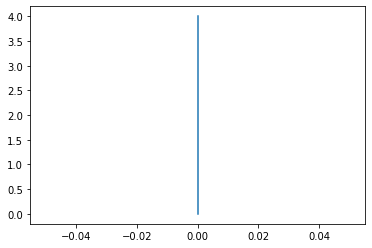

In [41]:
#Define titles for single demand dataframe
titles = []
titles.append("Governor Demand")
for x in range(gov_no):
    titles.append(f"GV{x+1} J")
    titles.append(f"GV{x+1} J_ratio")
    titles.append(f"GV{x+1} Region")

print(titles)
    
#Define dictionary for single demand dataframe
dictionary = {}
dictionary.update({titles[0] : gov_dmd})

for i in range(gov_no):
    dictionary.update({titles[2*i+1] : single_j_list[i]})
    dictionary.update({titles[2*i+2] : single_jratio_list[i]})
    dictionary.update({titles[2*i+3] : single_region[i]})


#Use dictionary to create a pandas dataframe
single_j_df = pd.DataFrame(dictionary)
print(single_j_df.head())
plt.plot(single_j_df["GV1 J_ratio"], single_j_df["GV1 Region"])

['Governor Demand', 'GV1 J', 'GV1 J_ratio', 'GV2 J', 'GV2 J_ratio', 'GV3 J', 'GV3 J_ratio', 'GV4 J', 'GV4 J_ratio', 'GV5 J', 'GV5 J_ratio', 'GV6 J', 'GV6 J_ratio', 'GV7 J', 'GV7 J_ratio', 'GV8 J', 'GV8 J_ratio']


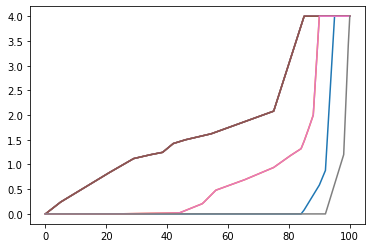

In [37]:
#Define titles for sequential demand dataframe
titles = []
titles.append("Governor Demand")
for x in range(gov_no):
    titles.append(f"GV{x+1} J")
    titles.append(f"GV{x+1} J_ratio")

print(titles)
    
#Define dictionary for sequential demand dataframe
dictionary = {}
dictionary.update({titles[0] : gov_dmd})

for i in range(gov_no):
    dictionary.update({titles[2*i+1] : seq_j_list[i]})
    dictionary.update({titles[2*i+2] : seq_jratio_list[i]})

#Use dictionary to create a pandas dataframe
single_j_df = pd.DataFrame(dictionary)
single_j_df

#Create a plot of all the J curves
for i in range(gov_no):
    plt.plot(single_j_df.iloc[:,0], single_j_df.iloc[:,i*2 +1])